In [6]:
%reset -f
# Sheet metal gauge reference: https://armstrongmetalcrafts.com/reference/SheetMetalGaugeWeight.aspx

# Manufacturing capabilities per value stream @ BAC
This code shows conservative boundaries for the allowed dimensions in each manufacturing value stream.

In [7]:
from capabilities import Capabilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xlwings as xw
import os
for app in xw.apps: app.quit()

regions = ['TL', 'MPB', 'APB']
part_set_names = ['HT', 'WC', 'WD', 'AH', 'SA']

all_stats = {
    name: {
        'total_parts': 0,
        'unique_part_counts': {region: 0 for region in regions},
        'unique_part_percentages': {region: 0 for region in regions},
        'total_weight': 0,
        'weight_counts': {region: 0 for region in regions},
        'weight_percentages': {region: 0 for region in regions},
    }
    for name in part_set_names
}

Extracting dimensions from cost calculator. CWB example to start with.

In [ ]:
path_e = r"C:\Users\EMedina\OneDrive - Baltimore Aircoil Company\Documents\Co-Op\Enrique + Stanley\Models\Cost\VS_Cost_Calc.xlsx"
path_s = r"C:\Users\ssalim\OneDrive - Baltimore Aircoil Company\Medina, Enrique Flores's files - Enrique + Stanley\Models\Cost\VS_Cost_Calc_Stanley.xlsx"
path = path_e if os.path.exists(path_e) else path_s
df = pd.read_excel(path, sheet_name='BAC Part List').iloc[1:].reset_index(drop=True)
df.columns = df.iloc[0]
df = df.iloc[1:].reset_index(drop=True)

c:\Users\EMedina\AppData\Local\anaconda3\envs\BAC\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [ ]:
def get_parts_by_set(df, part_set):
    if isinstance(part_set, str): part_set = [part_set]
    return df[df['Part Set'].isin(part_set)].copy()

def get_part_stats(local_stats):
    for region_stats in local_stats:
        for part_set_name in region_stats:
            all_stats[part_set_name]['total_parts'] += region_stats[part_set_name]['total_parts']
            all_stats[part_set_name]['total_weight'] += region_stats[part_set_name]['total_weight']
            for region in regions:               
                all_stats[part_set_name]['unique_part_counts'][region] += region_stats[part_set_name]['unique_part_counts'][region]
                all_stats[part_set_name]['weight_counts'][region] += region_stats[part_set_name]['weight_counts'][region]

    for part_set_name, stats in all_stats.items():
        total_parts = stats['total_parts']
        total_weight = stats['total_weight']
        unique_part_percentages = {}
        weight_percentages = {}
        for region in regions:
            unique_part_counts = stats['unique_part_counts'][region]
            unique_part_percentages[region] = (unique_part_counts / total_parts * 100) if total_parts > 0 else 0.0
            all_stats[part_set_name]['unique_part_percentages'] = unique_part_percentages
            weight_counts = stats['weight_counts'][region]
            weight_percentages[region] = (weight_counts / total_weight * 100) if total_weight > 0 else 0.0
            all_stats[part_set_name]['weight_percentages'] = weight_percentages

def plot_stacked_bar_chart(all_stats, title):
    """
    Plot a horizontal stacked bar chart with 3 colors (MPB, APB, TL) for each part set,
    ranked in descending order by MPB weight, and add percentage labels.

    Args:
        all_stats (dict): Dictionary containing stats for each part set.
        title (str): Title of the bar chart.
    """

    # Define regions and their colors
    regions = ['MPB', 'APB', 'TL']
    region_colors = {
        'APB': '#66c2a5',
        'MPB': '#4f8cd6',
        'TL': '#e74c3c'
    }

    # Remove 'HT' from part sets
    filtered_stats = {k: v for k, v in all_stats.items() if k != 'HT'}

    # Rank part sets by MPB weight in descending order
    ranked_part_sets = sorted(
        filtered_stats.keys(),
        key=lambda part_set: filtered_stats[part_set]['weight_counts']['MPB'],
        reverse=False
    )

    # Extract data for the bar chart
    part_sets = ranked_part_sets
    total_weights = [filtered_stats[part_set]['total_weight'] for part_set in part_sets]
    region_weights = {
        region: [filtered_stats[part_set]['weight_counts'][region] for part_set in part_sets]
        for region in regions
    }

    # Create a horizontal stacked bar chart
    y = np.arange(len(part_sets))  # Y-axis positions
    bar_height = 0.6

    fig, ax = plt.subplots(figsize=(10, 8))
    left = np.zeros(len(part_sets))  # Initialize the left position of the bars

    for region in regions:
        ax.barh(
            y, region_weights[region], bar_height,
            label=region, color=region_colors[region],
            left=left
        )
        left += np.array(region_weights[region])  # Update the left position for stacking

    # Add percentage labels to the bars
    for i, part_set in enumerate(part_sets):
        total_weight = total_weights[i]
        if total_weight > 0:
            left_position = 0  # Initialize the left position for centering
            for region in regions:
                region_weight = filtered_stats[part_set]['weight_counts'][region]
                percentage = (region_weight / total_weight) * 100
                if region_weight > 0:
                    # Calculate the center of the current region segment
                    x_position = left_position + region_weight / 2
                    ax.text(
                        x_position, i, f'{percentage:.0f}%', ha='center', va='center', fontsize=14, color='white', fontweight='bold'
                    )
                left_position += region_weight  # Update the left position for the next region

    # Add labels, title, and legend
    ax.set_yticks(y)
    # ax.set_xticks([])
    ax.set_yticklabels(part_sets, fontsize=14, fontweight='bold')

    ax.set_xlabel('Weight', fontsize=16, fontweight='bold')
    ax.set_title(title, fontsize=18, fontweight='bold')
    ax.legend(title='Mfg Method', fontsize=14, loc='lower right')

    plt.tight_layout()
    plt.show()

part_sets = []
for part_set in df['Part Set'].dropna().unique(): 
    part_sets.append(get_parts_by_set(df, part_set))
# part_sets.append(get_parts_by_set(df, 'GAC Reference (MPB)'))

# Plot manufacturing regions per material and gauge

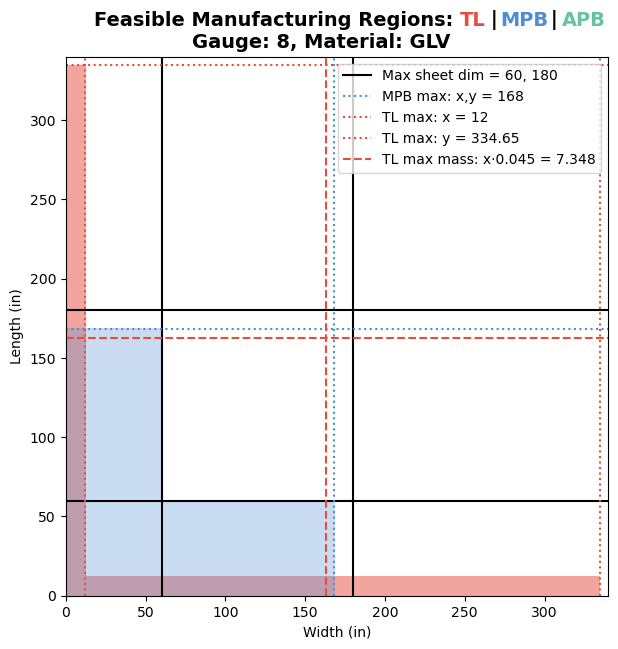

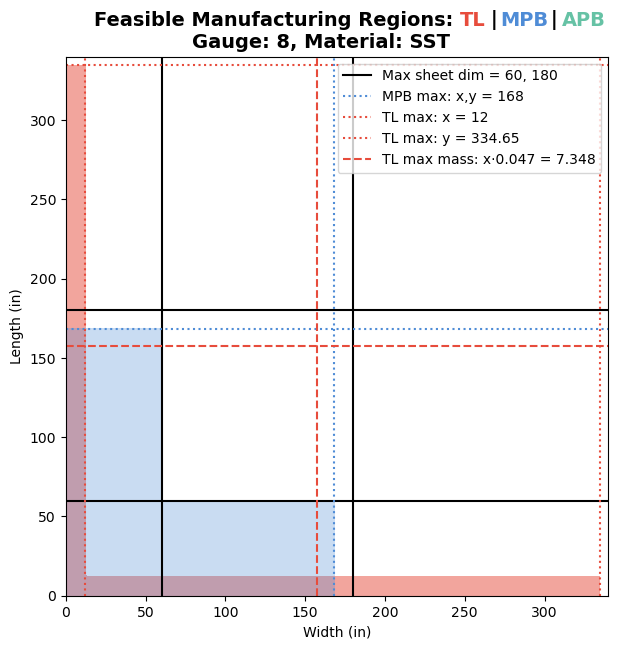

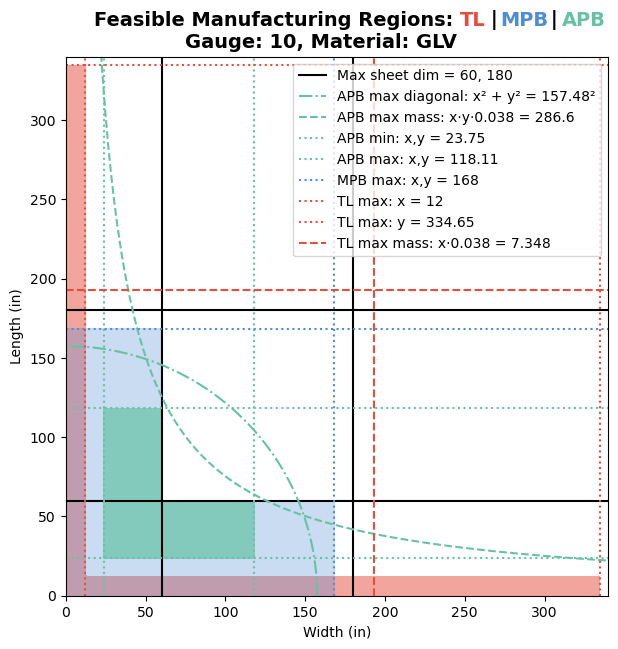

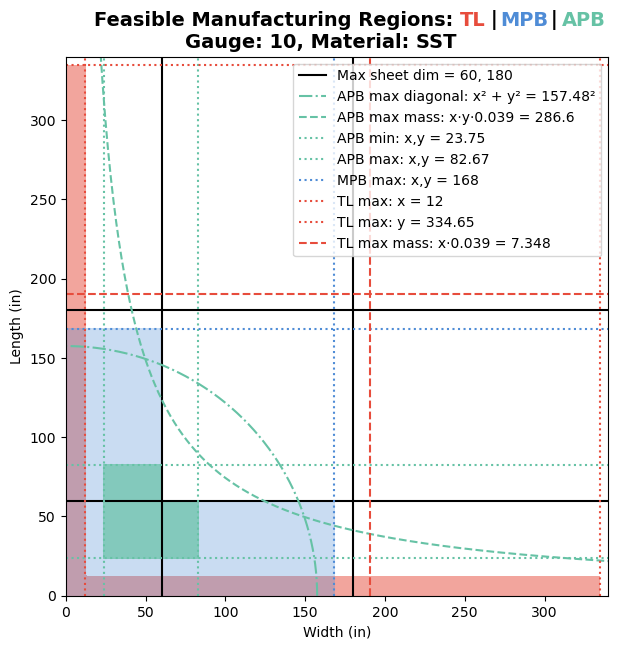

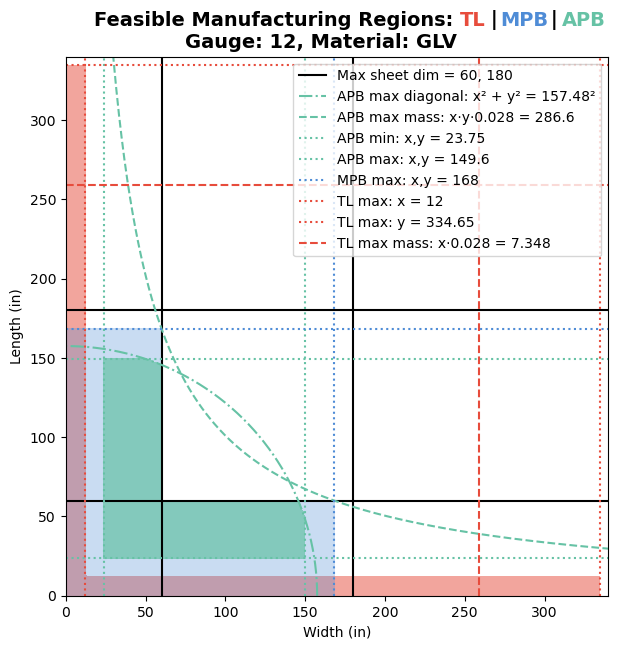

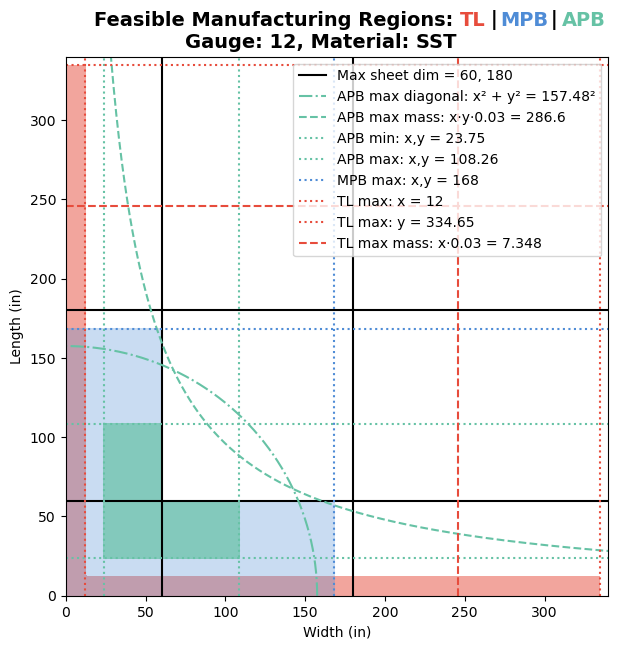

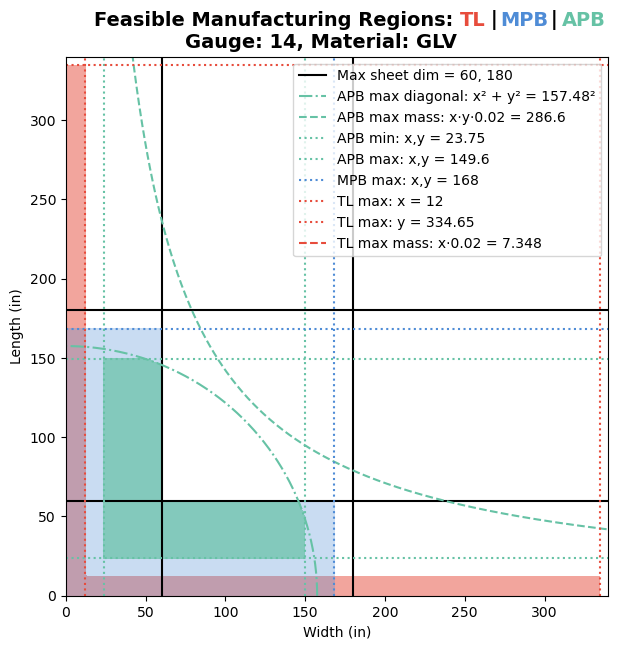

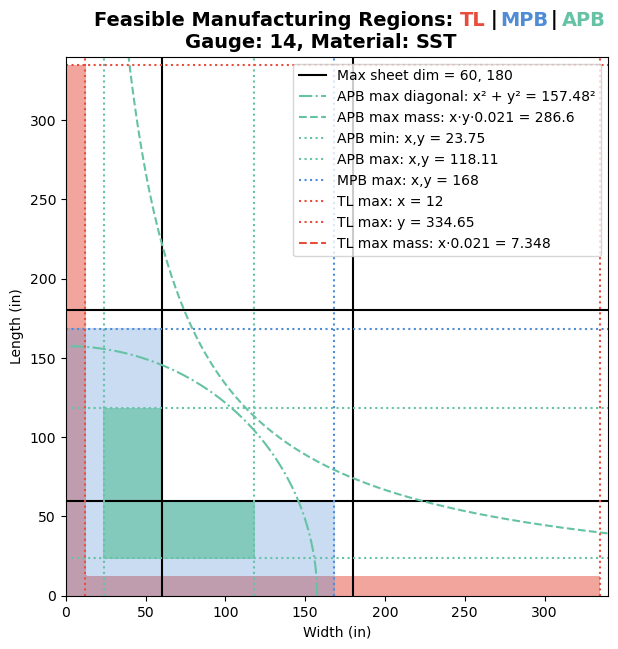

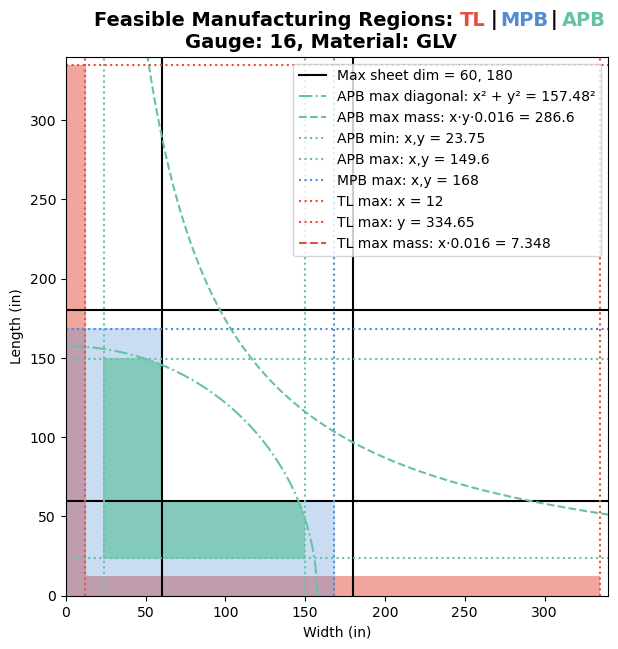

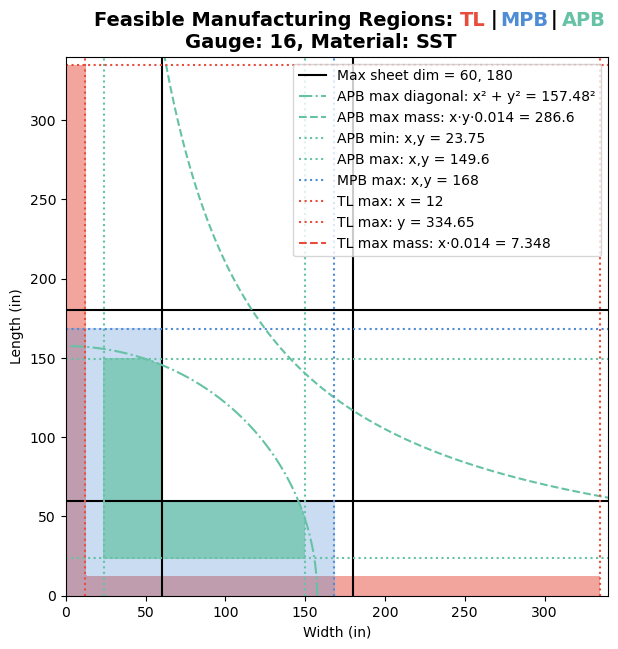

In [10]:
gauges = [8, 10, 12, 14, 16]
materials = ['GLV', 'SST']

# Plot all combinations
for gauge in gauges:
    for material in materials:
        cap = Capabilities(material, gauge)
        cap.plot_feasible_regions()
        part_set_stats = cap.add_part_sets(part_sets, get_stats=True)
        get_part_stats(part_set_stats)

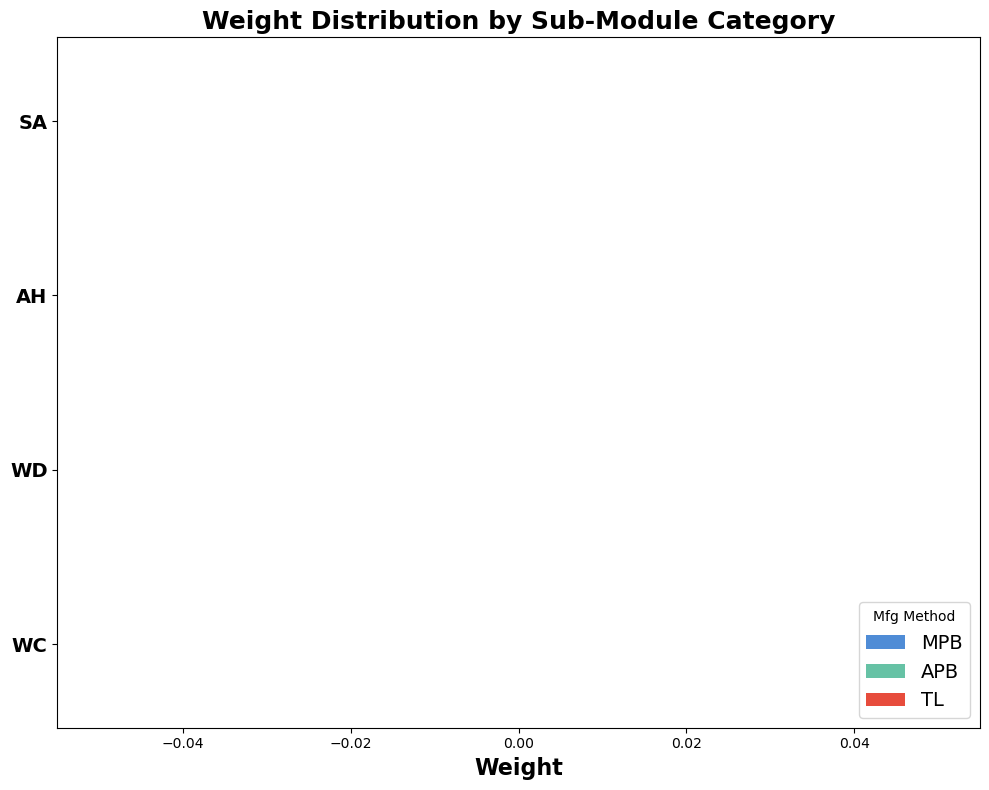

In [ ]:
# Plot the total weight distribution for each part set
plot_stacked_bar_chart(all_stats, 'Weight Distribution by Sub-Module Category')

Read 715 cost values
No feasible points for this region.
Read 393 cost values
Analyzing regions with multiple feasible processes...
Found 195 points with multiple feasible processes

COMPREHENSIVE STATISTICS FOR OPTIMAL REGIONS IN COMPETITIVE AREAS

MPB REGION: Never optimal in competitive areas

APB REGION: Never optimal in competitive areas

TL OPTIMAL REGION (COMPETITIVE AREAS):
  Coverage & Performance:
    • Times optimal: 195
    • Win rate: 100.0%
    • Optimal area: 4,735 sq in
    • Cost per sq in: $1.3685
  Cost Distribution When Optimal:
    • Minimum cost: $9.52
    • Maximum cost: $93.55
    • Average cost: $33.23
    • Median cost: $25.53
    • Standard deviation: $25.11
    • 25th percentile: $9.59
    • 75th percentile: $51.67
    • Cost range span: $84.03
    • Coefficient of variation: 75.6%
  Competitive Advantage:
    • Minimum advantage: $11.82
    • Maximum advantage: $33.21
    • Average advantage: $23.10
    • Median advantage: $26.68
    • Advantage std dev: $6

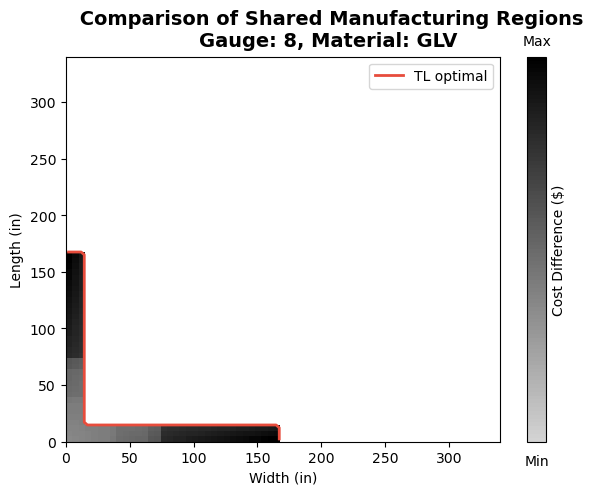

Average cost difference per sq in for TL: $0.0685
Standard deviation of cost difference per sq in for TL: $0.0810
No competitive areas for APB.
Read 715 cost values
No feasible points for this region.
Read 393 cost values
Analyzing regions with multiple feasible processes...
Found 195 points with multiple feasible processes

COMPREHENSIVE STATISTICS FOR OPTIMAL REGIONS IN COMPETITIVE AREAS

MPB REGION: Never optimal in competitive areas

APB REGION: Never optimal in competitive areas

TL OPTIMAL REGION (COMPETITIVE AREAS):
  Coverage & Performance:
    • Times optimal: 195
    • Win rate: 100.0%
    • Optimal area: 4,735 sq in
    • Cost per sq in: $2.5943
  Cost Distribution When Optimal:
    • Minimum cost: $9.54
    • Maximum cost: $211.61
    • Average cost: $62.99
    • Median cost: $46.30
    • Standard deviation: $57.95
    • 25th percentile: $9.61
    • 75th percentile: $97.14
    • Cost range span: $202.07
    • Coefficient of variation: 92.0%
  Competitive Advantage:
    • Mi

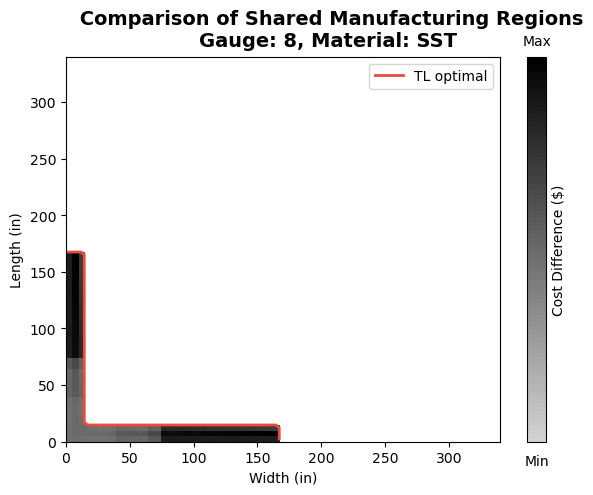

Average cost difference per sq in for TL: $0.0597
Standard deviation of cost difference per sq in for TL: $0.0805
No competitive areas for APB.
Read 715 cost values
Read 240 cost values
Read 393 cost values
Analyzing regions with multiple feasible processes...
Found 435 points with multiple feasible processes

COMPREHENSIVE STATISTICS FOR OPTIMAL REGIONS IN COMPETITIVE AREAS

MPB REGION: Never optimal in competitive areas

APB OPTIMAL REGION (COMPETITIVE AREAS):
  Coverage & Performance:
    • Times optimal: 240
    • Win rate: 55.2%
    • Optimal area: 5,827 sq in
    • Cost per sq in: $5.9538
  Cost Distribution When Optimal:
    • Minimum cost: $41.47
    • Maximum cost: $267.46
    • Average cost: $144.56
    • Median cost: $146.18
    • Standard deviation: $53.16
    • 25th percentile: $102.01
    • 75th percentile: $182.20
    • Cost range span: $225.99
    • Coefficient of variation: 36.8%
  Competitive Advantage:
    • Minimum advantage: $17.40
    • Maximum advantage: $47.67
 

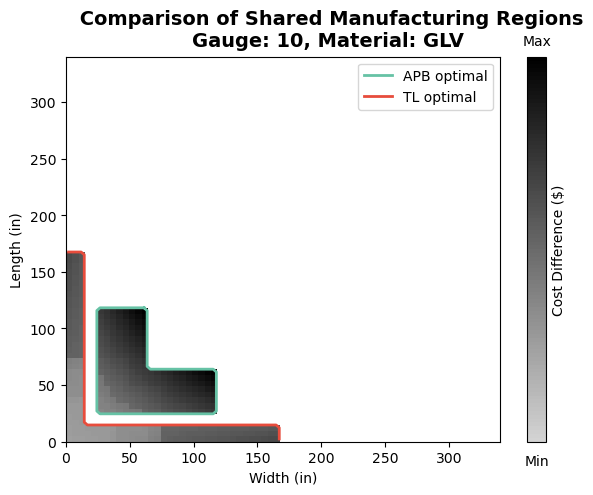

Average cost difference per sq in for TL: $0.0665
Standard deviation of cost difference per sq in for TL: $0.0804
Average cost difference per sq in for APB: $0.0118
Standard deviation of cost difference per sq in for APB: $0.0037
Read 715 cost values
Read 128 cost values
Read 393 cost values
Analyzing regions with multiple feasible processes...
Found 323 points with multiple feasible processes

COMPREHENSIVE STATISTICS FOR OPTIMAL REGIONS IN COMPETITIVE AREAS

MPB REGION: Never optimal in competitive areas

APB OPTIMAL REGION (COMPETITIVE AREAS):
  Coverage & Performance:
    • Times optimal: 128
    • Win rate: 39.6%
    • Optimal area: 3,108 sq in
    • Cost per sq in: $10.3677
  Cost Distribution When Optimal:
    • Minimum cost: $75.39
    • Maximum cost: $474.25
    • Average cost: $251.73
    • Median cost: $232.60
    • Standard deviation: $99.03
    • 25th percentile: $174.96
    • 75th percentile: $329.59
    • Cost range span: $398.87
    • Coefficient of variation: 39.3%
  C

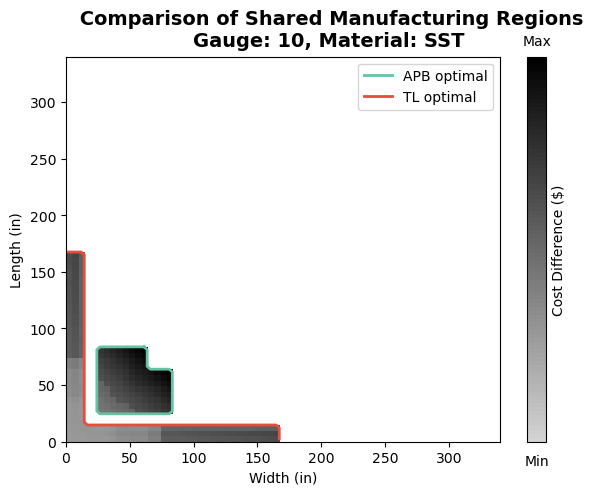

Average cost difference per sq in for TL: $0.0652
Standard deviation of cost difference per sq in for TL: $0.0813
Average cost difference per sq in for APB: $0.0152
Standard deviation of cost difference per sq in for APB: $0.0043
Read 715 cost values
Read 336 cost values
Read 393 cost values
Analyzing regions with multiple feasible processes...
Found 531 points with multiple feasible processes

COMPREHENSIVE STATISTICS FOR OPTIMAL REGIONS IN COMPETITIVE AREAS

MPB REGION: Never optimal in competitive areas

APB OPTIMAL REGION (COMPETITIVE AREAS):
  Coverage & Performance:
    • Times optimal: 336
    • Win rate: 63.3%
    • Optimal area: 8,158 sq in
    • Cost per sq in: $5.2550
  Cost Distribution When Optimal:
    • Minimum cost: $30.99
    • Maximum cost: $249.30
    • Average cost: $127.59
    • Median cost: $129.95
    • Standard deviation: $50.97
    • 25th percentile: $89.57
    • 75th percentile: $164.39
    • Cost range span: $218.31
    • Coefficient of variation: 39.9%
  Com

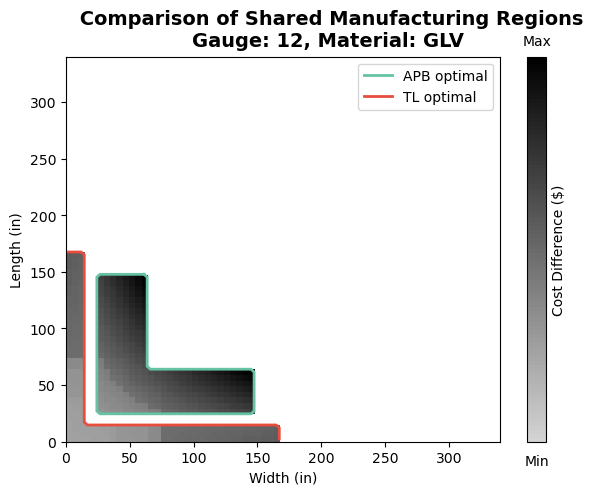

Average cost difference per sq in for TL: $0.0657
Standard deviation of cost difference per sq in for TL: $0.0801
Average cost difference per sq in for APB: $0.0099
Standard deviation of cost difference per sq in for APB: $0.0030
Read 715 cost values
Read 208 cost values
Read 393 cost values
Analyzing regions with multiple feasible processes...
Found 403 points with multiple feasible processes

COMPREHENSIVE STATISTICS FOR OPTIMAL REGIONS IN COMPETITIVE AREAS

MPB REGION: Never optimal in competitive areas

APB OPTIMAL REGION (COMPETITIVE AREAS):
  Coverage & Performance:
    • Times optimal: 208
    • Win rate: 51.6%
    • Optimal area: 5,050 sq in
    • Cost per sq in: $9.8997
  Cost Distribution When Optimal:
    • Minimum cost: $57.78
    • Maximum cost: $476.99
    • Average cost: $240.37
    • Median cost: $230.13
    • Standard deviation: $99.59
    • 25th percentile: $164.84
    • 75th percentile: $315.81
    • Cost range span: $419.21
    • Coefficient of variation: 41.4%
  Co

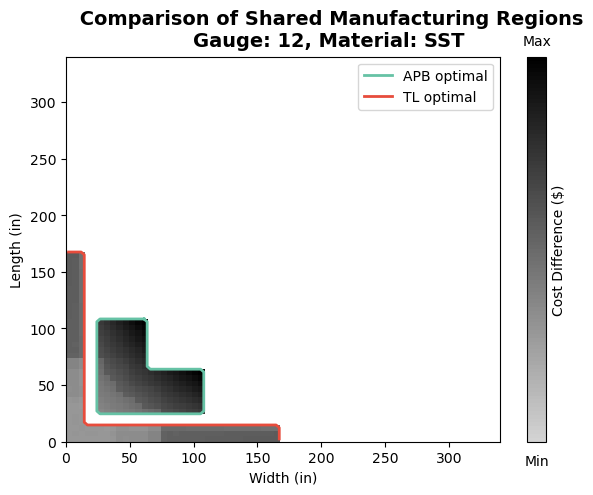

Average cost difference per sq in for TL: $0.0592
Standard deviation of cost difference per sq in for TL: $0.0798
Average cost difference per sq in for APB: $0.0110
Standard deviation of cost difference per sq in for APB: $0.0032
Read 715 cost values
Read 336 cost values
Read 393 cost values
Analyzing regions with multiple feasible processes...
Found 531 points with multiple feasible processes

COMPREHENSIVE STATISTICS FOR OPTIMAL REGIONS IN COMPETITIVE AREAS

MPB REGION: Never optimal in competitive areas

APB OPTIMAL REGION (COMPETITIVE AREAS):
  Coverage & Performance:
    • Times optimal: 336
    • Win rate: 63.3%
    • Optimal area: 8,158 sq in
    • Cost per sq in: $3.9953
  Cost Distribution When Optimal:
    • Minimum cost: $26.91
    • Maximum cost: $189.21
    • Average cost: $97.01
    • Median cost: $93.02
    • Standard deviation: $38.31
    • 25th percentile: $72.35
    • 75th percentile: $128.89
    • Cost range span: $162.30
    • Coefficient of variation: 39.5%
  Compe

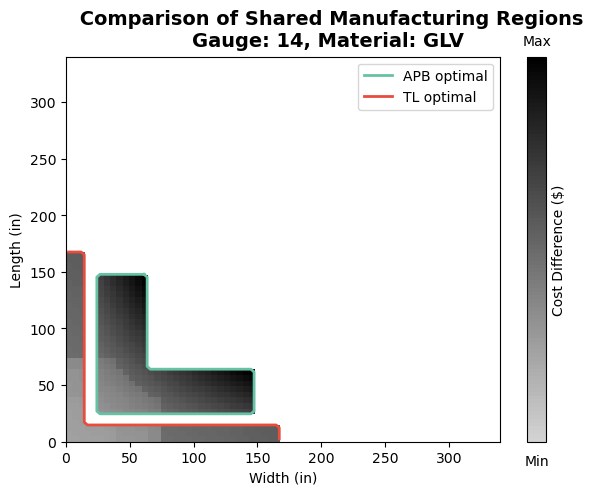

Average cost difference per sq in for TL: $0.0661
Standard deviation of cost difference per sq in for TL: $0.0800
Average cost difference per sq in for APB: $0.0097
Standard deviation of cost difference per sq in for APB: $0.0030
Read 715 cost values
Read 240 cost values
Read 393 cost values
Analyzing regions with multiple feasible processes...
Found 435 points with multiple feasible processes

COMPREHENSIVE STATISTICS FOR OPTIMAL REGIONS IN COMPETITIVE AREAS

MPB REGION: Never optimal in competitive areas

APB OPTIMAL REGION (COMPETITIVE AREAS):
  Coverage & Performance:
    • Times optimal: 240
    • Win rate: 55.2%
    • Optimal area: 5,827 sq in
    • Cost per sq in: $7.8370
  Cost Distribution When Optimal:
    • Minimum cost: $46.28
    • Maximum cost: $384.60
    • Average cost: $190.29
    • Median cost: $184.16
    • Standard deviation: $78.93
    • 25th percentile: $128.60
    • 75th percentile: $240.37
    • Cost range span: $338.32
    • Coefficient of variation: 41.5%
  Co

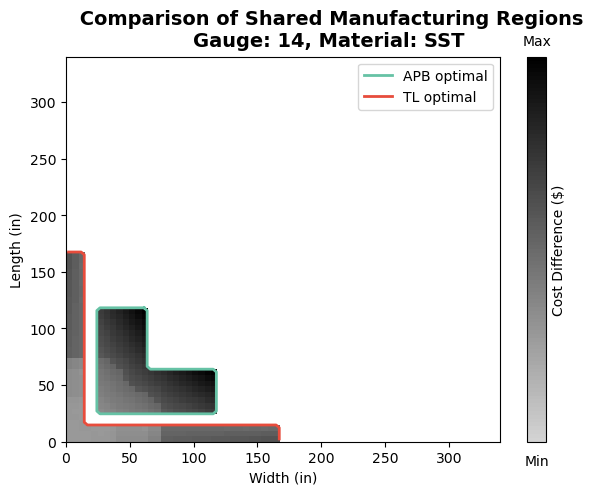

Average cost difference per sq in for TL: $0.0605
Standard deviation of cost difference per sq in for TL: $0.0796
Average cost difference per sq in for APB: $0.0104
Standard deviation of cost difference per sq in for APB: $0.0031
Read 715 cost values
Read 336 cost values
Read 393 cost values
Analyzing regions with multiple feasible processes...
Found 531 points with multiple feasible processes

COMPREHENSIVE STATISTICS FOR OPTIMAL REGIONS IN COMPETITIVE AREAS

MPB REGION: Never optimal in competitive areas

APB OPTIMAL REGION (COMPETITIVE AREAS):
  Coverage & Performance:
    • Times optimal: 336
    • Win rate: 63.3%
    • Optimal area: 8,158 sq in
    • Cost per sq in: $3.4258
  Cost Distribution When Optimal:
    • Minimum cost: $22.24
    • Maximum cost: $162.28
    • Average cost: $83.18
    • Median cost: $81.57
    • Standard deviation: $31.71
    • 25th percentile: $60.71
    • 75th percentile: $101.59
    • Cost range span: $140.04
    • Coefficient of variation: 38.1%
  Compe

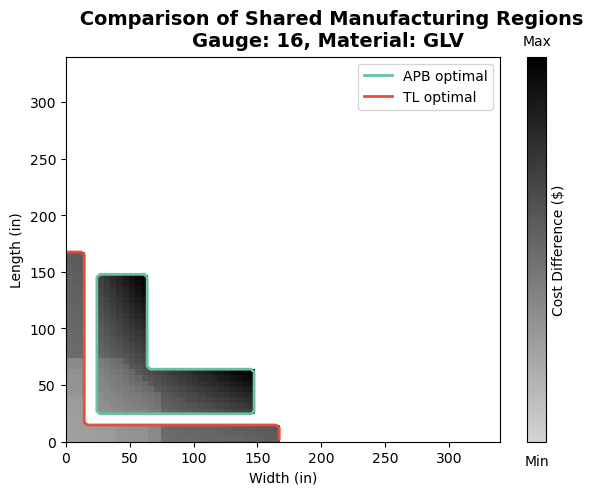

Average cost difference per sq in for TL: $0.0661
Standard deviation of cost difference per sq in for TL: $0.0799
Average cost difference per sq in for APB: $0.0096
Standard deviation of cost difference per sq in for APB: $0.0030
Read 715 cost values
Read 336 cost values
Read 393 cost values
Analyzing regions with multiple feasible processes...
Found 531 points with multiple feasible processes

COMPREHENSIVE STATISTICS FOR OPTIMAL REGIONS IN COMPETITIVE AREAS

MPB REGION: Never optimal in competitive areas

APB OPTIMAL REGION (COMPETITIVE AREAS):
  Coverage & Performance:
    • Times optimal: 336
    • Win rate: 63.3%
    • Optimal area: 8,158 sq in
    • Cost per sq in: $7.4247
  Cost Distribution When Optimal:
    • Minimum cost: $37.09
    • Maximum cost: $381.33
    • Average cost: $180.28
    • Median cost: $174.68
    • Standard deviation: $75.86
    • 25th percentile: $124.64
    • 75th percentile: $231.02
    • Cost range span: $344.24
    • Coefficient of variation: 42.1%
  Co

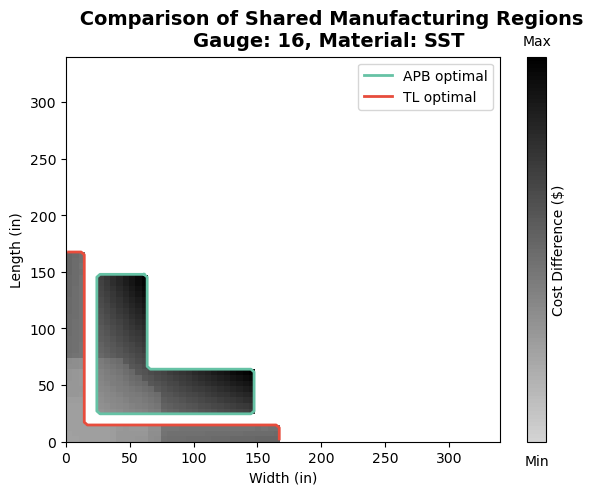

Average cost difference per sq in for TL: $0.0614
Standard deviation of cost difference per sq in for TL: $0.0796
Average cost difference per sq in for APB: $0.0095
Standard deviation of cost difference per sq in for APB: $0.0029


In [12]:
for app in xw.apps:
    app.quit()

# # Diagonal increase from (40,30) to (100,80)
# cap = Capabilities('GLV', 10)
# results = cap.plot_cost_run_chart(path, 5, 5, 55, 55, 'diagonal', 5)

gauges = [8, 10, 12, 14, 16]
materials = ['GLV', 'SST']
for gauge in gauges:
    for material in materials:
        cap = Capabilities(material, gauge)
        # cap.plot_individual_cost_heatmap(path, fastener_spacing=3, bolt_diameter=0.3125)
        # cap.plot_optimal_cost_heatmap(path, fastener_spacing=6, bolt_diameter=0.3125)
        cap.plot_cost_difference_heatmap(path, fastener_spacing=6, bolt_diameter=0.3125)